In [58]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import matthews_corrcoef, f1_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torcheval.metrics import BinaryAccuracy, BinaryF1Score, BinaryConfusionMatrix

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Load data
data_folder = "Pre-Processed Dark-Eyed Junco Data/"
env = pd.read_csv(data_folder + "environmental_vars_checklists_md_jan.csv")
checklists = pd.read_csv(data_folder + "checklists_zf_md_deju_jan.csv")
train_df = pd.merge(checklists, env, on="checklist_id")

features = ['year', 'day_of_year', 'hours_of_day',
            'effort_hours', 'effort_distance_km', 'effort_speed_kmph',
            'number_observers'] + \
           [col for col in train_df.columns if col.startswith(('pland_', 'ed_', 'elevation_'))]

X = train_df[features]
y = train_df['species_observed'].astype(int)

## Dense NN

In [59]:
# 2. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=28)

# 3. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# 4. Define the model
class SpeciesNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = SpeciesNet(X_train.shape[1]).to(device)
criterion = nn.BCELoss().to(device)
accuracy = BinaryAccuracy().to(device)
f1 = BinaryF1Score().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. Training loop
train_accuracy = []
train_f1 = []
val_accuracy = []
val_f1 = []
for epoch in range(20):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        accuracy.update(preds.squeeze(1), yb.squeeze(1))
        f1.update(preds.squeeze(1), yb.squeeze(1))
    train_accuracy.append(accuracy.compute().cpu().numpy())
    train_f1.append(f1.compute().cpu().numpy())
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    accuracy.reset()
    f1.reset()
    model.eval()
    with torch.no_grad():
        train_probs = model(X_train_tensor).cpu().numpy().flatten()

    cal = IsotonicRegression(out_of_bounds='clip')
    cal.fit(train_probs, y_train)

    with torch.no_grad():
        for xb, yb in val_loader:
            val_probs_raw = model(X_val_tensor)
    #         accuracy.update(val_probs_raw.squeeze(1), yb.squeeze(1))
    #         f1.update(val_probs_raw.squeeze(1), yb.squeeze(1))
    # val_accuracy.append(accuracy.compute().cpu().numpy())
    # val_f1.append(f1.compute().cpu().numpy())

    val_probs_cal = cal.predict(val_probs_raw.cpu().numpy().flatten())

    # 7. Threshold tuning
    best_mcc, best_f1, best_thresh = -1, -1, 0
    for t in np.linspace(0, 1, 100):
        preds = (val_probs_cal > t).astype(int)
        m = matthews_corrcoef(y_val, preds)
        f = f1_score(y_val, preds)
        if m > best_mcc:
            best_mcc, best_f1, best_thresh = m, f, t

    print(f"Best threshold: {best_thresh:.3f}, MCC: {best_mcc:.3f}, F1: {best_f1:.3f}")
    accuracy.reset()
    f1.reset()
    model.train()

# 6. Predict and calibrate with isotonic regression
model.eval()
with torch.no_grad():
    train_probs = model(X_train_tensor).cpu().numpy().flatten()

cal = IsotonicRegression(out_of_bounds='clip')
cal.fit(train_probs, y_train)

with torch.no_grad():
    val_probs_raw = model(X_val_tensor).cpu().numpy().flatten()
val_probs_cal = cal.predict(val_probs_raw)

# 7. Threshold tuning
best_mcc, best_f1, best_thresh = -1, -1, 0
for t in np.linspace(0, 1, 100):
    preds = (val_probs_cal > t).astype(int)
    m = matthews_corrcoef(y_val, preds)
    f = f1_score(y_val, preds)
    if m > best_mcc:
        best_mcc, best_f1, best_thresh = m, f, t

print(f"Best threshold: {best_thresh:.3f}, MCC: {best_mcc:.3f}, F1: {best_f1:.3f}")

# 8. Predict on grid
grid = pd.read_csv(data_folder + "environmental_vars_prediction_grid_md.csv")
grid["observation_date"] = pd.to_datetime("2023-01-15")
grid["year"] = grid["observation_date"].dt.year
grid["day_of_year"] = grid["observation_date"].dt.dayofyear
grid["hours_of_day"] = 7.5
grid["effort_distance_km"] = 2
grid["effort_hours"] = 1
grid["effort_speed_kmph"] = 2
grid["number_observers"] = 1

X_grid = grid[features]
X_grid_scaled = scaler.transform(X_grid)
X_grid_tensor = torch.tensor(X_grid_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    grid_probs_raw = model(X_grid_tensor).cpu().numpy().flatten()
grid_probs_cal = cal.predict(grid_probs_raw)
grid["encounter_rate"] = np.clip(grid_probs_cal, 0, 1)

# Save outputs
grid_output = grid[["cell_id", "x", "y", "encounter_rate"]]
grid_output["in_range"] = (grid_output["encounter_rate"] > best_thresh).astype(int)
grid_output.to_csv("junco_nn_predictions.csv", index=False)

# Save validation predictions for R
results_df = pd.DataFrame({
    'obs': y_val,
    'pred': val_probs_cal
})
results_df.to_csv("dnn_predictions_for_r.csv", index=False)

Epoch 1, Loss: 1225.3523
Best threshold: 0.404, MCC: 0.350, F1: 0.628
Epoch 2, Loss: 1174.2213
Best threshold: 0.404, MCC: 0.372, F1: 0.635
Epoch 3, Loss: 1148.1610
Best threshold: 0.455, MCC: 0.393, F1: 0.623
Epoch 4, Loss: 1129.8798
Best threshold: 0.404, MCC: 0.404, F1: 0.650
Epoch 5, Loss: 1113.9284
Best threshold: 0.434, MCC: 0.411, F1: 0.641
Epoch 6, Loss: 1101.5114
Best threshold: 0.465, MCC: 0.415, F1: 0.642
Epoch 7, Loss: 1089.1711
Best threshold: 0.475, MCC: 0.420, F1: 0.640
Epoch 8, Loss: 1079.5828
Best threshold: 0.475, MCC: 0.429, F1: 0.642
Epoch 9, Loss: 1068.7953
Best threshold: 0.424, MCC: 0.427, F1: 0.658
Epoch 10, Loss: 1059.7649
Best threshold: 0.475, MCC: 0.430, F1: 0.647
Epoch 11, Loss: 1052.3025
Best threshold: 0.485, MCC: 0.431, F1: 0.642
Epoch 12, Loss: 1045.4245
Best threshold: 0.475, MCC: 0.446, F1: 0.659
Epoch 13, Loss: 1039.3058
Best threshold: 0.485, MCC: 0.442, F1: 0.650
Epoch 14, Loss: 1032.3644
Best threshold: 0.434, MCC: 0.445, F1: 0.661
Epoch 15, Loss:

C:\Users\alonz\AppData\Local\Temp\ipykernel_19764\1181298370.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_output["in_range"] = (grid_output["encounter_rate"] > best_thresh).astype(int)


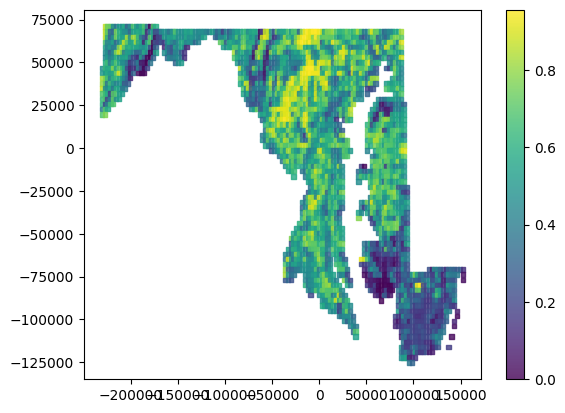

In [60]:
plt.scatter(grid_output['x'], grid_output['y'], c = grid_output['encounter_rate'].values, s = 10, marker = 's', alpha = 0.8)
plt.colorbar()
plt.show()

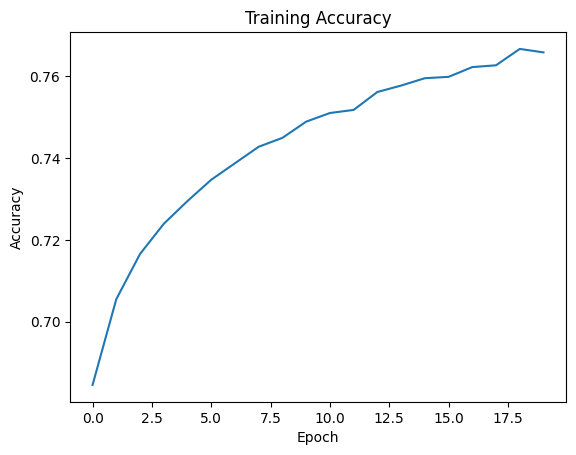

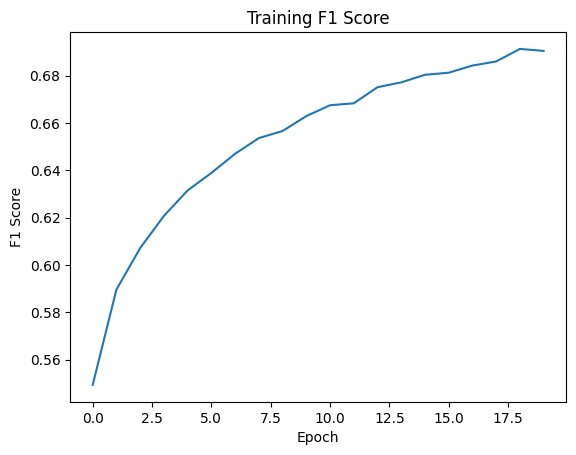

In [61]:
## Plot accuracy and f1
plt.plot(range(20), train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()
plt.savefig('train_accuracy.png')
plt.close()
plt.plot(range(20), train_f1)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training F1 Score')
plt.show()
plt.savefig('train_f1.png')
plt.close()
# plt.plot(range(20), val_accuracy)
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Validation Accuracy')
# plt.savefig('val_accuracy.png')
# plt.close()
# plt.plot(range(20), val_f1)
# plt.xlabel('Epoch')
# plt.ylabel('F1 Score')
# plt.title('Validation F1 Score')
# plt.savefig('val_f1.png')
# plt.close()

## CNN

In [62]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class SpeciesNet1DCNN(nn.Module):
    def __init__(self, input_length: int):
        super().__init__()
        # 1) 1D-CNN feature extractor
        self.cnn = nn.Sequential(
            # in_channels=1, out_channels=16, length stays 39 (padding=1)
            nn.Conv1d(1, 16, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool1d(2),            # -> length = floor(39/2) = 19

            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),            # -> length = floor(19/2) = 9
        )
        # compute flattened size after two pools
        conv_out_len = input_length // 2 // 2    # 39→19→9
        flattened_dim = 32 * conv_out_len        # 32 channels × length 9 = 288
        self.fc = nn.Sequential(
            nn.Linear(flattened_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: (batch, 1, 39)
        x = self.cnn(x)                 # -> (batch, 32, 9)
        x = x.view(x.size(0), -1)       # -> (batch, 32*9)
        return self.fc(x)               # -> (batch, 1)

# ——— data prep ———
# 2. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=28)
# add a channel dimension of size 1:
X_train_1d = X_train.reshape(-1, 1, 39)  
X_val_1d   = X_val.reshape(  -1, 1, 39)

# 3. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_1d, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

X_val_tensor = torch.tensor(X_val_1d, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor,   y_val_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)

# ——— model, loss, optimizer ———
model = SpeciesNet1DCNN(input_length=39).to(device)
criterion = nn.BCELoss().to(device)
accuracy = BinaryAccuracy().to(device)
f1 = BinaryF1Score().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. Training loop
train_accuracy = []
train_f1 = []
val_accuracy = []
val_f1 = []
for epoch in range(20):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        accuracy.update(preds.squeeze(1), yb.squeeze(1))
        f1.update(preds.squeeze(1), yb.squeeze(1))
    train_accuracy.append(accuracy.compute().cpu().numpy())
    train_f1.append(f1.compute().cpu().numpy())
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    accuracy.reset()
    f1.reset()
    model.eval()
    with torch.no_grad():
        train_probs = model(X_train_tensor).cpu().numpy().flatten()

    cal = IsotonicRegression(out_of_bounds='clip')
    cal.fit(train_probs, y_train)

    with torch.no_grad():
        for xb, yb in val_loader:
            val_probs_raw = model(X_val_tensor)
    #         accuracy.update(val_probs_raw.squeeze(1), yb.squeeze(1))
    #         f1.update(val_probs_raw.squeeze(1), yb.squeeze(1))
    # val_accuracy.append(accuracy.compute().cpu().numpy())
    # val_f1.append(f1.compute().cpu().numpy())

    val_probs_cal = cal.predict(val_probs_raw.cpu().numpy().flatten())

    # 7. Threshold tuning
    best_mcc, best_f1, best_thresh = -1, -1, 0
    for t in np.linspace(0, 1, 100):
        preds = (val_probs_cal > t).astype(int)
        m = matthews_corrcoef(y_val, preds)
        f = f1_score(y_val, preds)
        if m > best_mcc:
            best_mcc, best_f1, best_thresh = m, f, t

    print(f"Best threshold: {best_thresh:.3f}, MCC: {best_mcc:.3f}, F1: {best_f1:.3f}")
    accuracy.reset()
    f1.reset()
    model.train()


Epoch 1, Loss: 1250.6961
Best threshold: 0.485, MCC: 0.341, F1: 0.578
Epoch 2, Loss: 1175.4243
Best threshold: 0.434, MCC: 0.388, F1: 0.629
Epoch 3, Loss: 1141.3686
Best threshold: 0.465, MCC: 0.388, F1: 0.613
Epoch 4, Loss: 1114.6629
Best threshold: 0.475, MCC: 0.420, F1: 0.645
Epoch 5, Loss: 1093.4773
Best threshold: 0.505, MCC: 0.426, F1: 0.629
Epoch 6, Loss: 1074.9283
Best threshold: 0.465, MCC: 0.435, F1: 0.659
Epoch 7, Loss: 1059.8485
Best threshold: 0.495, MCC: 0.440, F1: 0.651
Epoch 8, Loss: 1044.8313
Best threshold: 0.444, MCC: 0.439, F1: 0.666
Epoch 9, Loss: 1030.4367
Best threshold: 0.424, MCC: 0.445, F1: 0.673
Epoch 10, Loss: 1018.8483
Best threshold: 0.444, MCC: 0.454, F1: 0.674
Epoch 11, Loss: 1006.5980
Best threshold: 0.404, MCC: 0.462, F1: 0.687
Epoch 12, Loss: 992.6582
Best threshold: 0.444, MCC: 0.457, F1: 0.678
Epoch 13, Loss: 983.3691
Best threshold: 0.414, MCC: 0.452, F1: 0.677
Epoch 14, Loss: 971.4567
Best threshold: 0.414, MCC: 0.456, F1: 0.683
Epoch 15, Loss: 96

In [63]:
# 6. Predict and calibrate with isotonic regression
model.eval()

# ——— get train probs ———
with torch.no_grad():
    train_probs = model(X_train_tensor).cpu().numpy().flatten()

cal = IsotonicRegression(out_of_bounds='clip')
cal.fit(train_probs, y_train)

# ——— get val probs ———
with torch.no_grad():
    val_probs_raw = model(X_val_tensor).cpu().numpy().flatten()
val_probs_cal = cal.predict(val_probs_raw)

# 7. Threshold tuning on validation set
best_mcc, best_f1, best_thresh = -1, -1, 0.0
for t in np.linspace(0, 1, 101):
    preds_t = (val_probs_cal > t).astype(int)
    m = matthews_corrcoef(y_val, preds_t)
    f = f1_score(y_val, preds_t)
    if m > best_mcc:
        best_mcc, best_f1, best_thresh = m, f, t

print(f"Best threshold: {best_thresh:.3f}, MCC: {best_mcc:.3f}, F1: {best_f1:.3f}")

# 8. Predict on grid
grid = pd.read_csv(data_folder + "environmental_vars_prediction_grid_md.csv")
grid["observation_date"] = pd.to_datetime("2023-01-15")
grid["year"]           = grid["observation_date"].dt.year
grid["day_of_year"]    = grid["observation_date"].dt.dayofyear
grid["hours_of_day"]   = 7.5
grid["effort_distance_km"] = 2
grid["effort_hours"]       = 1
grid["effort_speed_kmph"]  = 2
grid["number_observers"]   = 1

# select & scale features
X_grid = grid[features]
X_grid_scaled = scaler.transform(X_grid)

# reshape for 1D-CNN: (N, 39) -> (N, 1, 39)
X_grid_1d = X_grid_scaled.reshape(-1, 1, X_grid_scaled.shape[1])
X_grid_tensor = torch.tensor(X_grid_1d, dtype=torch.float32).to(device)

# if your grid is very large, you could also batch it:
# grid_ds    = TensorDataset(X_grid_tensor)
# grid_loader= DataLoader(grid_ds, batch_size=1024, shuffle=False)
# grid_probs_raw = []
# with torch.no_grad():
#     for (xb,) in grid_loader:
#         grid_probs_raw.append(model(xb).cpu().numpy().flatten())
# grid_probs_raw = np.concatenate(grid_probs_raw)

# otherwise, just do it in one go:
with torch.no_grad():
    grid_probs_raw = model(X_grid_tensor).cpu().numpy().flatten()

# calibrate & clip
grid_probs_cal = cal.predict(grid_probs_raw)
grid["encounter_rate"] = np.clip(grid_probs_cal, 0, 1)

# assemble & save
grid_output = grid[["cell_id", "x", "y", "encounter_rate"]].copy()
grid_output["in_range"] = (grid_output["encounter_rate"] > best_thresh).astype(int)
grid_output.to_csv("junco_cnn_predictions.csv", index=False)

# also save validation predictions for R
results_df = pd.DataFrame({
    'obs':  y_val,
    'pred': val_probs_cal
})
results_df.to_csv("cnn_predictions_for_r.csv", index=False)

Best threshold: 0.450, MCC: 0.464, F1: 0.680


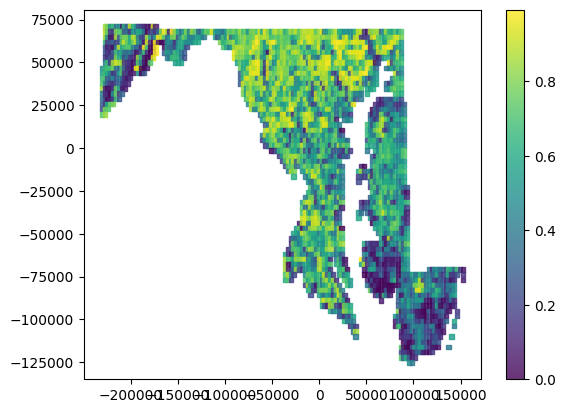

In [64]:
plt.scatter(grid_output['x'], grid_output['y'], c = grid_output['encounter_rate'].values, s = 10, marker = 's', alpha = 0.8)
plt.colorbar()
plt.show()

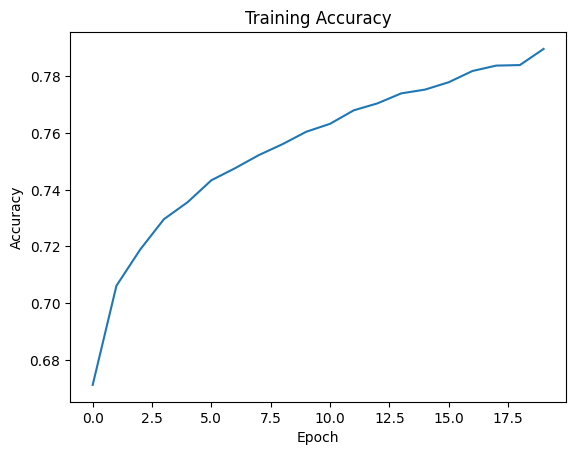

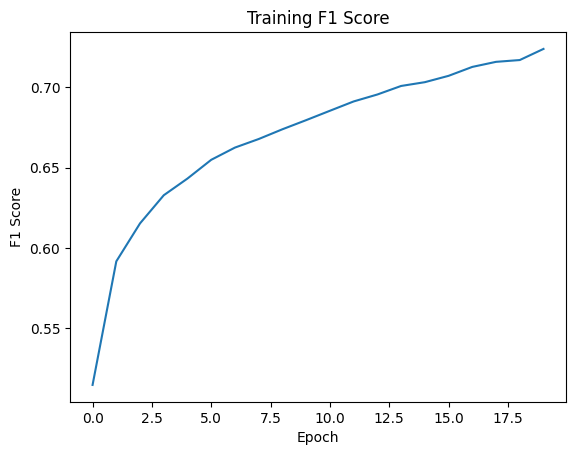

In [65]:
## Plot accuracy and f1
plt.plot(range(20), train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()
plt.savefig('train_accuracy.png')
plt.close()
plt.plot(range(20), train_f1)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training F1 Score')
plt.show()
plt.savefig('train_f1.png')
plt.close()
# plt.plot(range(20), val_accuracy)
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Validation Accuracy')
# plt.savefig('val_accuracy.png')
# plt.close()
# plt.plot(range(20), val_f1)
# plt.xlabel('Epoch')
# plt.ylabel('F1 Score')
# plt.title('Validation F1 Score')
# plt.savefig('val_f1.png')
# plt.close()